# cnv

### calculate cnv

In [1]:
library(Seurat)
library(stringr)
suppressMessages(library(ReactomePA))
suppressMessages(library(clusterProfiler))
suppressMessages(library(org.Hs.eg.db))
library(ggsci)
library(ggplot2)
library(scales)
library(dplyr)
library(harmony) 
library(pheatmap)
library(dbscan)
require(pscl)
library(Ridit)
library(purrr)
library(R.utils)
library(plyr)
library(scImpute)
library(parallel)
R.utils::setOption("clusterProfiler.download.method","auto")

Attaching SeuratObject


Attaching package: ‘dplyr’


The following object is masked from ‘package:AnnotationDbi’:

    select


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Rcpp


Attaching package: ‘dbscan’


The following object is masked from ‘package:stats’:

    as.dendrogram


Loading required package: pscl

Classes and Methods for R developed in the
Political Science Computational Laboratory
Department of Political Science
Stanford 

In [2]:
epi = readRDS('~/HPV/res/seurat_rds/epi.rds')
merged_data = readRDS('~/HPV/res/seurat_rds/merged_data.rds')

In [3]:
unique(epi$doublet)

[1] "Singlet"                "B_Epithelial"           "Epithelial_T"          
 [4] "Epithelial_Neutrophil"  "Epithelial_Fibroblast"  "Epithelial_NK"         
 [7] "Epithelial_Plasma"      "B_T"                    "Neutrophil_NK"         
[10] "Epithelial_Monocyte"    "Endothelial_Epithelial" "Epithelial_Macrophage" 
[13] "Fibroblast_T"           "Plasma_T"               "NK_Plasma"

In [4]:
epi = epi[,!(epi$seurat_clusters %in% c('4','5','8','7','9'))]
epi = epi[,epi$nFeature_RNA <= 8000 & epi$nCount_RNA <= 50000]
merged_data = merged_data[,merged_data$major!='Epithelial']
merged_data = merged_data[,merged_data$nFeature_RNA <= 5000 & merged_data$nCount_RNA <= 25000 & merged_data$doublet == 'Singlet']

In [5]:
dim(merged_data)

[1] 28849 61270

In [10]:
#ch1 chr10 .... chr2 chr21 ...
gene_loc = read.table('~/HPV/ref/genome/hs/genes.bed',header = FALSE, sep = '\t')
gene_loc = gene_loc[!duplicated(gene_loc$V4),]
gene_loc = gene_loc[which(gene_loc$V4 %in% rownames(epi)),]
epi=epi[match(gene_loc$V4,rownames(epi)),]
merged_data=merged_data[match(gene_loc$V4,rownames(merged_data)),]
dim(epi)
dim(merged_data)

[1] 28659 10303

[1] 28659 61270

In [11]:
unique(merged_data$major)

[1] "T"           "B"           "NK"          "pDC"         "Fibroblast" 
 [6] "Endothelial" "Neutrophil"  "DC"          "Macrophage"  "Monocyte"   
[11] "Plasma"      "Mast"

In [12]:
expr = GetAssayData(epi,slot = 'data')
mean_ref = lapply(unique(merged_data$major),function(x){
    return(rowMeans(merged_data[,merged_data$major == x]))
}) %>% reduce(cbind)
colnames(mean_ref) = unique(merged_data$major)
mean_immune = mean_ref[,c('T','B','NK','pDC','Neutrophil','DC','Macrophage','Monocyte','Plasma','Mast')] %>% rowMeans()
mean_stromal = mean_ref[,c('Fibroblast','Endothelial')] %>% rowMeans()
mean_ref = cbind(mean_immune,mean_stromal) %>% rowMeans()
expr_dif = expr - mean_ref

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.2 GiB”


In [13]:
#remove chromosomes with gene number less than 100
freq = table(gene_loc$V1)
valid_chr = names(freq)[freq > 100]
length(valid_chr)
valid_chr

[1] 23

[1] "chr1"  "chr10" "chr11" "chr12" "chr13" "chr14" "chr15" "chr16" "chr17"
[10] "chr18" "chr19" "chr2"  "chr20" "chr21" "chr22" "chr3"  "chr4"  "chr5" 
[19] "chr6"  "chr7"  "chr8"  "chr9"  "chrX"

In [14]:
result <- mclapply(1:23, function(i) {
    message(i)
    gene_loc = gene_loc[gene_loc$V1 == valid_chr[i],]
    cnv_scores = list()
    for (gene in gene_loc$V4[51:(nrow(gene_loc)-50)]){
        gene_index = which(rownames(expr_dif) == gene)
        window_index = window_index = c((gene_index-50):(gene_index+50))
        cnv_scores[[gene]] = colSums(expr_dif[window_index,])/101
    }
    cnv_score = cnv_scores %>% reduce(rbind)
    rownames(cnv_score) = names(cnv_scores)
    return(cnv_score)
}, mc.cores = 23)

In [15]:
cnv_score = result %>% reduce(rbind)
cnv_score=t(scale(cnv_score))
saveRDS(cnv_score, file = '~/HPV/res/epi/hpv_inte/cnv_score.rds')

### calculate pvalue

In [16]:
library(Seurat)
library(stringr)
suppressMessages(library(ReactomePA))
suppressMessages(library(clusterProfiler))
suppressMessages(library(org.Hs.eg.db))
library(ggsci)
library(ggplot2)
library(scales)
library(dplyr)
library(harmony) 
library(pheatmap)
library(dbscan)
require(pscl)
library(Ridit)
library(purrr)
library(R.utils)
library(plyr)
library(scImpute)
library(parallel)
options(bedtools.path = "~/anaconda3/envs/gencode/bin/")
library(bedtoolsr)
library(ggrepel)

Warning message in fun(libname, pkgname):
“bedtoolsr was built with bedtools version 2.30.0 but you have version 2.31.0 installed. Function syntax may have changed and wrapper will not function correctly. To fix this, please install bedtools version 2.30.0 and either add it to your PATH or run:
options(bedtools.path = \"[bedtools path]\")”


In [17]:
epi = readRDS('~/HPV/res/seurat_rds/epi.rds')
epi = epi[,!(epi$seurat_clusters %in% c('4','5','8','7','9'))]
epi = epi[,epi$nFeature_RNA <= 8000 & epi$nCount_RNA <= 50000]

In [18]:
cnv_score = readRDS('~/HPV/res/epi/hpv_inte/cnv_score.rds')

In [19]:
dim(epi)
dim(cnv_score)

[1] 28668 10303

[1] 10303 26332

In [20]:
flank_gene_top = readRDS('~/HPV/res/epi/hpv_inte/flank_gene_top.rds')
within_gene_top = readRDS('~/HPV/res/epi/hpv_inte/within_gene_top.rds')

In [21]:
within_genes = unique(unlist(unlist(str_split(epi$Hs_gene_within,';'))))
within_genes = within_genes[-which(within_genes=='')]
flank_genes = unique(unlist(unlist(str_split(epi$Hs_gene_flank,';'))))
flank_genes = flank_genes[-which(flank_genes=='')]

In [22]:
hpv_within =  matrix(0, ncol = ncol(epi),nrow = length(within_genes))
rownames(hpv_within) = within_genes
colnames(hpv_within) = colnames(epi)
hpv_flank =  matrix(0, ncol = ncol(epi),nrow = length(flank_genes))
rownames(hpv_flank) = flank_genes
colnames(hpv_flank) = colnames(epi)
within_indx = which(epi$Hs_gene_within!='')
flank_index = which(epi$Hs_gene_flank!='')
for (j in 1:nrow(hpv_within)){
    hpv_within[j,] = ifelse(str_detect(epi$Hs_gene_within,within_genes[j]),yes = 1,no = 0)
}
for (j in 1:nrow(hpv_flank)){
    hpv_flank[j,] = ifelse(str_detect(epi$Hs_gene_flank,flank_genes[j]),yes = 1,no = 0)
}
hpv_within = CreateSeuratObject(counts = hpv_within)
hpv_within@meta.data = epi@meta.data
hpv_flank = CreateSeuratObject(counts = hpv_flank)
hpv_flank@meta.data = epi@meta.data

In [23]:
dim(hpv_flank)
dim(hpv_within)

[1]   393 10303

[1]   610 10303

In [24]:
cal_chi = function(inte_genes, inte_expr){
    pvalue = c()
    enrich = c()
    genes = c()
    ninte = c()
    for (gene in inte_genes){
        if (gene %in% colnames(cnv_score)){ 
            hpv_inte = GetAssayData(inte_expr)[gene,] %>% mapvalues(from = c(0,1),to = c('non-integrated','integrated'))
            hpv_inte = factor(hpv_inte,levels = c('integrated','non-integrated'))
            cnv = cnv_score[,gene]
            cnv_level = rep('gain',ncol(inte_expr))
            cnv_level[cnv < 0]  = 'loss'
            freq = table(hpv_inte,cnv_level)
            if (sum(freq < 5)==0){
                message(gene)
                res = fisher.test(freq)
                print(freq)
                print(res)
                p = res$p.value
                odds_ratio = res$estimate
                genes = c(genes, gene)
                enrich = c(enrich, odds_ratio)
                pvalue = c(pvalue, p)
                ninte = c(ninte, length(which(hpv_inte == 'integrated')))
            }
        }
    }
    return(data.frame(genes = genes, enrich = enrich, pvalue = pvalue, ninte = ninte))
}

In [25]:
flank_res = cal_chi(flank_gene_top$genes,hpv_flank)

In [26]:
flank_res

<0 x 0 matrix>

In [27]:
within_res = cal_chi(within_gene_top$genes,hpv_within)

NRG1



                cnv_level
hpv_inte         gain loss
  integrated        5   11
  non-integrated 2882 7405

	Fisher's Exact Test for Count Data

data:  freq
p-value = 0.7828
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.3178357 3.6499022
sample estimates:
odds ratio 
  1.167865 



CNBD1



                cnv_level
hpv_inte         gain loss
  integrated      147   46
  non-integrated 4415 5695

	Fisher's Exact Test for Count Data

data:  freq
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 2.933756 5.885165
sample estimates:
odds ratio 
  4.121604 



NMNAT2



                cnv_level
hpv_inte         gain loss
  integrated       10   22
  non-integrated 5318 4953

	Fisher's Exact Test for Count Data

data:  freq
p-value = 0.02159
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.1787964 0.9328469
sample estimates:
odds ratio 
   0.42338 



STARD8



                cnv_level
hpv_inte         gain loss
  integrated       33   77
  non-integrated 2391 7802

	Fisher's Exact Test for Count Data

data:  freq
p-value = 0.1137
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.8982887 2.1344752
sample estimates:
odds ratio 
  1.398409 



TLN2



                cnv_level
hpv_inte         gain loss
  integrated       34   48
  non-integrated 4474 5747

	Fisher's Exact Test for Count Data

data:  freq
p-value = 0.7379
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.5675383 1.4443014
sample estimates:
odds ratio 
   0.90986 



SLC8A1



                cnv_level
hpv_inte         gain loss
  integrated        8   67
  non-integrated 1964 8264

	Fisher's Exact Test for Count Data

data:  freq
p-value = 0.07541
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.2080531 1.0503657
sample estimates:
odds ratio 
 0.5024512 



GLUL



                cnv_level
hpv_inte         gain loss
  integrated      205   62
  non-integrated 6284 3752

	Fisher's Exact Test for Count Data

data:  freq
p-value = 1.255e-06
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.474540 2.674816
sample estimates:
odds ratio 
  1.974068 



PTPN13



                cnv_level
hpv_inte         gain loss
  integrated       15  251
  non-integrated 1871 8166

	Fisher's Exact Test for Count Data

data:  freq
p-value = 1.536e-09
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.1434683 0.4399065
sample estimates:
odds ratio 
 0.2608474 



In [28]:
within_res

genes,enrich,pvalue,ninte
<chr>,<dbl>,<dbl>,<int>
NRG1,1.1678654,7.828465e-01,16
CNBD1,4.1216036,1.765391e-19,193
NMNAT2,0.4233800,2.158998e-02,32
STARD8,1.3984086,1.137040e-01,110
TLN2,0.9098600,7.378575e-01,82
SLC8A1,0.5024512,7.540947e-02,75
GLUL,1.9740682,1.254776e-06,267
PTPN13,0.2608474,1.535951e-09,266


In [29]:
gene_loc = read.table('~/HPV/ref/genome/hs/genes.bed',header = FALSE, sep = '\t')
gene_loc = gene_loc[!duplicated(gene_loc$V4),]

In [30]:
res = rbind(flank_res,within_res)
gene_loc = read.table('~/HPV/ref/genome/hs/genes.bed',header = FALSE, sep = '\t')
gene_loc = gene_loc[!duplicated(gene_loc$V4),]
res[,c('chr','start','end')] = gene_loc[match(res$genes,gene_loc$V4),c(1,2,3)]
res = res[,c('chr','start','end', 'genes', 'enrich', 'pvalue')]
res = bt.sort(res)
colnames(res) = c('chr','start','end', 'genes', 'enrich', 'pvalue')

In [31]:
chr_band = read.table('~/HPV/ref/genome/hs/cytoBand.txt',header = FALSE, sep = '\t')

In [32]:
band = bt.intersect(chr_band,res,wa = TRUE)
res$Band = paste0(band$V1,band$V4)
res$Band = gsub('chr','',res$Band)
saveRDS(res,file = '~/HPV/res/epi/hpv_inte/cnv_geom_point.rds')

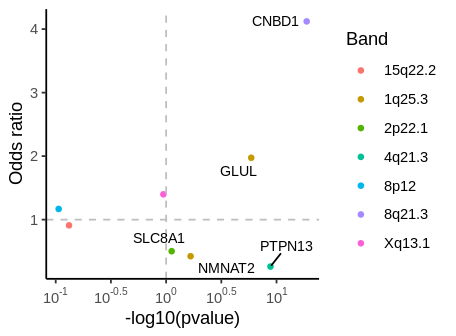

In [33]:
options(repr.plot.width = 3.8, repr.plot.height = 2.8)
ggplot(res, aes(x=-log10(pvalue), y=enrich)) +
  geom_point(aes(color = Band), size = 1.2) + 
  scale_x_log10(breaks = trans_breaks("log10", function(x) 10^x), labels = trans_format("log10", math_format(10^.x))) + 
  labs(x = '-log10(pvalue)', y = 'Odds ratio') + 
  scale_fill_discrete(name = "Band") + 
  geom_hline(mapping=aes(yintercept=1), color="gray",linetype = 2) +
  geom_vline(mapping=aes(xintercept=-log10(0.1)), color="gray",linetype = 2) + 
  geom_text_repel( 
    data=res %>% filter(pvalue<=0.1),
    aes(label=genes),
    size = 3
  ) + theme_classic()

In [34]:
cnv_genes = list()
gos = list()
for (i in 1:nrow(within_res)){
    target = within_res[i,'genes']
    gene_loc[gene_loc$V4==target,]
    loc_sub = gene_loc[gene_loc$V1 == res$chr[res$genes == target],]
    index = which(loc_sub$V4==target)
    genes = loc_sub$V4[c((index-50):(index+50))]
    go <- enrichGO(genes,ont = "BP",OrgDb = 'org.Hs.eg.db',keyType = "SYMBOL")
    cnv_genes[[target]] = genes
    gos[[target]] = go
}

In [35]:
cnv_genes[['CNBD1']]

[1] "AC009902.2" "FABP5"      "AC018616.1" "PMP2"       "FABP9"     
  [6] "FABP4"      "AC023644.1" "FABP12"     "IMPA1"      "SLC10A5"   
 [11] "ZFAND1"     "CHMP4C"     "AC132219.1" "SNX16"      "LINC02235" 
 [16] "AC060765.2" "LINC02839"  "AC060765.1" "AC105031.2" "LINC01419" 
 [21] "AC015522.1" "RALYL"      "LRRCC1"     "AC011773.4" "E2F5"      
 [26] "AC011773.1" "RBIS"       "CA13"       "AC011773.3" "AC011773.2"
 [31] "CA1"        "CA3"        "CA3-AS1"    "CA2"        "AC084734.1"
 [36] "AC100801.1" "LINC02849"  "AC100801.2" "ATP6V0D2"   "PSKH2"     
 [41] "AC023194.3" "AC084128.1" "SLC7A13"    "AC103760.1" "WWP1"      
 [46] "RMDN1"      "CPNE3"      "CNGB3"      "AC090572.3" "AC090572.2"
 [51] "CNBD1"      "AF121898.1" "DCAF4L2"    "AC037450.1" "MMP16"     
 [56] "AC090578.1" "AC090578.2" "AC090578.3" "AF117829.1" "RIPK2"     
 [61] "OSGIN2"     "NBN"        "DECR1"      "CALB1"      "AC004083.1"
 [66] "LINC00534"  "LINC01030"  "TMEM64"     "AC106038.1" "NECAB1"    
 [71] "AC103770.1" "C8orf88"    "PIP4P2"     "AC087439.1" "AC087439.2"
 [76] "OTUD6B-AS1" "OTUD6B"     "LRRC69"     "SLC26A7"    "AC103409.1"
 [81] "RUNX1T1"    "AF181450.1" "AC022695.2" "AC022695.3" "AC091096.1"
 [86] "AC104211.2" "AC104211.4" "AC104211.1" "AC104211.3" "AC117834.2"
 [91] "AC117834.1" "TRIQK"      "C8orf87"    "LINC00535"  "AC016885.1"
 [96] "AC016885.2" "FAM92A"     "AC120053.1" "AC010834.3" "RBM12B"    
[101] "AC010834.1"

In [36]:
gos[['CNBD1']]@result[1:10,c('Description','geneID')]

,Description,geneID
,<chr>,<chr>
GO:0015849,organic acid transport,FABP5/PMP2/FABP9/FABP4/FABP12/SLC10A5/SLC7A13/SLC26A7
GO:0006730,one-carbon metabolic process,CA13/CA1/CA3/CA2
GO:0015908,fatty acid transport,FABP5/PMP2/FABP9/FABP4/FABP12
GO:0006869,lipid transport,FABP5/PMP2/FABP9/FABP4/FABP12/SLC10A5
GO:0010876,lipid localization,FABP5/PMP2/FABP9/FABP4/FABP12/SLC10A5
GO:0120162,positive regulation of cold-induced thermogenesis,FABP5/FABP4/DECR1
GO:0070050,neuron cellular homeostasis,CA2/CALB1
GO:0106106,cold-induced thermogenesis,FABP5/FABP4/DECR1
GO:0120161,regulation of cold-induced thermogenesis,FABP5/FABP4/DECR1


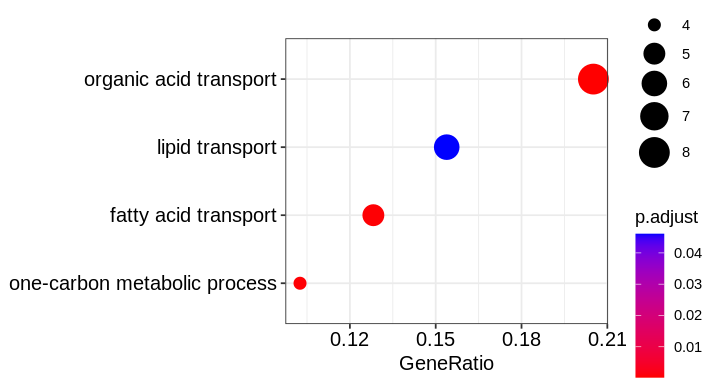

In [37]:
options(repr.plot.width =6, repr.plot.height = 3.2)
dotplot(gos[['CNBD1']])

In [38]:
saveRDS(gos[['CNBD1']],file = '~/HPV/res/epi/hpv_inte/inte_go.rds')

In [39]:
table(epi$curated[str_detect(epi$Hs_gene_within,'CNBD1')])/table(epi$curated)


Epi_COL17A1   Epi_MKI67   Epi_KRT6C   Epi_ERO1A  Epi_OXPHOS      others 
0.011775362 0.035087719 0.025023607 0.009493671                         
  Epi_MHCII 
0.004566210 

In [40]:
res = table(epi$curated[str_detect(epi$Hs_gene_within,'CNBD1')])/table(epi$curated)
res = data.frame(ct = names(res),number = as.vector(res))

In [41]:
res

ct,number
<chr>,<dbl>
Epi_COL17A1,0.011775362
Epi_MKI67,0.035087719
Epi_KRT6C,0.025023607
Epi_ERO1A,0.009493671
Epi_OXPHOS,NaN
others,NaN
Epi_MHCII,0.004566210


In [42]:
saveRDS(res,file = '~/HPV/res/epi/hpv_inte/CNBD1_number.rds')

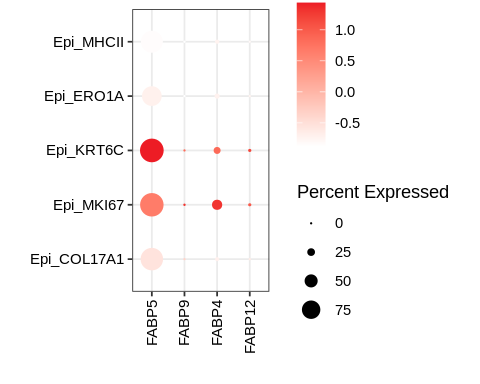

In [43]:
options(repr.plot.width = 4, repr.plot.height = 3.2)
DotPlot(epi,features = c('FABP5','FABP9','FABP4','FABP12'),group.by = 'curated',cols = c('white','#ED1C25')) + theme_bw() + labs(x = '',y='') +
      theme(
      axis.text.x = element_text(family="Helvetica",size=9,colour = "black",angle = 90, vjust = 0.5, hjust=1),
      axis.text.y = element_text(family="Helvetica",size=9,colour = "black"),
      strip.text.x = element_text(size = 12, color = "black", family="Helvetica"),
      strip.background = element_blank())

# survival

In [44]:
library(reshape2)
library(survival)
library(data.table)
library(stringr)
library(survminer)
library(ggsurvfit)
library(GSEABase)
library(AUCell)


Attaching package: ‘data.table’


The following objects are masked from ‘package:reshape2’:

    dcast, melt


The following object is masked from ‘package:purrr’:

    transpose


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:IRanges’:

    shift


The following objects are masked from ‘package:S4Vectors’:

    first, second


Loading required package: ggpubr


Attaching package: ‘ggpubr’


The following object is masked from ‘package:plyr’:

    mutate



Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma


Loading required package: annotate

Loading required package: XML

Loading required package: graph


Attaching package: ‘graph’


The following object is masked from ‘package:XML’:

    addNode


The following object is masked from ‘package:plyr’:

    join


The following object is masked from ‘package:stringr’:

    boundary




In [45]:
expr = fread('~/HPV/data/rna/tcga/RNA',header = T, sep = '\t')
expr = as.data.frame(expr)
rownames(expr) = expr[,1]
expr = expr[,-1]

table(unlist(lapply(colnames(expr), function(x){
    unlist(str_split(x,'-'))[4]
})))
expr = expr[,str_which(colnames(expr),'-01')]


 01  06  11 
303   2   3 

In [46]:
squamous = read.table('~/HPV/data/rna/tcga/squamous_patient.tsv',header = TRUE,sep = '\t')
survive = read.table('~/HPV/data/rna//tcga//Survival',header = TRUE,sep = '\t')
survive = survive[str_which(survive$sample,'-01'),]

In [47]:
patient = list(unique(squamous$Case.ID), gsub('-01','',colnames(expr),survive$X_PATIENT)) %>% purrr::reduce(intersect)
expr = expr[,which(gsub('-01','',colnames(expr)) %in% patient)]
survive = survive[survive$X_PATIENT %in% patient,]

In [48]:
colnames(expr) = gsub('-01','',colnames(expr))
expr = expr[,patient]
rownames(survive) = survive$X_PATIENT
survive = survive[patient,]

In [49]:
survive$sig = colMeans(expr[c('FABP4','FABP5','FABP12','FABP9'),])

$sig


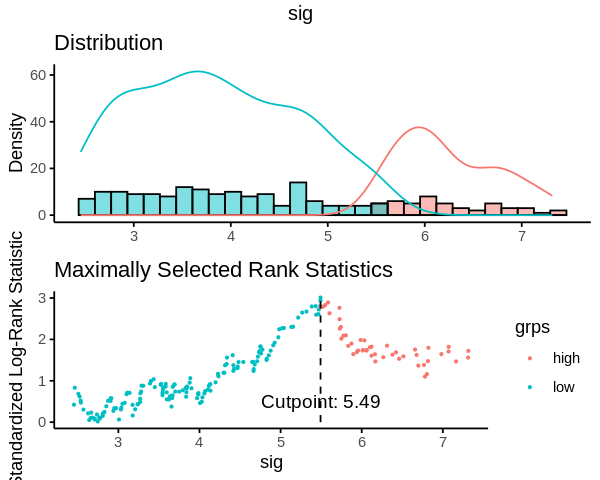

In [50]:
res.cut <- surv_cutpoint(survive, time = "OS.time", event = "OS",
                         variables = c("sig") 
                         )
options(repr.plot.width = 5, repr.plot.height = 4)
plot(res.cut,'sig')

In [51]:
sur = function(survive){
    p = survfit2(Surv(OS.time,OS) ~ signature, data = survive[survive$signature!='others',]) %>% 
      ggsurvfit() + 
        add_risktable(risktable_stats = 'n.risk', theme = theme_test()+
                      theme(axis.title = element_blank(),title = element_blank(),
                            axis.text.x = element_blank(),
                            axis.ticks.x=element_blank(),
                            axis.text.y = element_text(color="black",size=10)),
                    combine_groups=F,risktable_height = 0.23) +
        annotate(geom = "text", x = 0, y = 0.2, label = paste0('P = ',p.value) ,hjust = 0, vjust = 1) + 
        scale_x_continuous(breaks = seq(0,6000,1000)) + 
        theme_classic() + 
        theme(legend.position = c(0.8,0.8),axis.title.x = element_text(size = 13),axis.title.y = element_text(size = 13),
              axis.text.x = element_text(size = 12),
              axis.text.y = element_text(size = 12),
              legend.text = element_text(size = 11),
            ) + 
        scale_color_manual(values = colors,
                            breaks = c('High', 'Low'),
                            labels = c('High', 'Low'))
    return(p)
}

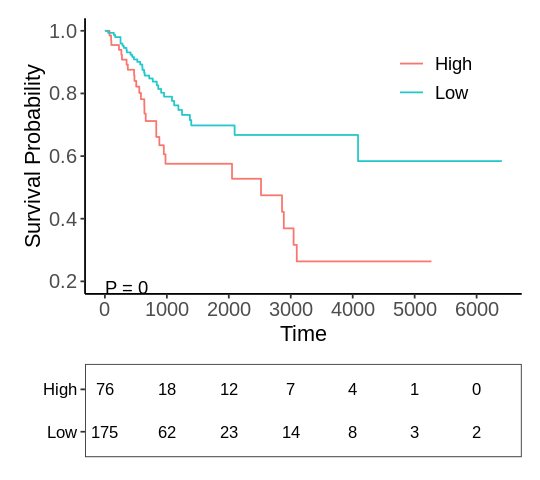

In [52]:
survive$signature = c('others')
survive$signature[survive$sig >= 5.49] = 'High'
survive$signature[survive$sig < 5.49] = 'Low'
colors = c("#F8766D", "#22C8CC")
names(colors) = c('High', 'Low')
res = survdiff(Surv(OS.time,OS) ~ signature, data = survive[survive$signature!='others',])
p.value <- round(1 - pchisq(res$chisq, length(res$n) -1),digits = 2)
#plot
options(repr.plot.width = 4.5, repr.plot.height = 4)
sur(survive)

In [53]:
saveRDS(survive,file = '~/HPV/res/epi/hpv_inte/survive.rds')

In [54]:
p.value

[1] 0

In [1]:
rds = readRDS('~/HPV/res/epi/hpv_inte/inte_go.rds')

In [4]:
rds@result

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0015849,GO:0015849,organic acid transport,8/39,324/18903,2.647148e-07,0.0002033010,0.0001761050,FABP5/PMP2/FABP9/FABP4/FABP12/SLC10A5/SLC7A13/SLC26A7,8
GO:0006730,GO:0006730,one-carbon metabolic process,4/39,39/18903,1.207754e-06,0.0004637777,0.0004017372,CA13/CA1/CA3/CA2,4
GO:0015908,GO:0015908,fatty acid transport,5/39,101/18903,1.964306e-06,0.0005028622,0.0004355934,FABP5/PMP2/FABP9/FABP4/FABP12,5
GO:0006869,GO:0006869,lipid transport,6/39,433/18903,2.398692e-04,0.0460548949,0.0398940428,FABP5/PMP2/FABP9/FABP4/FABP12/SLC10A5,6
GO:0010876,GO:0010876,lipid localization,6/39,483/18903,4.301250e-04,0.0660671986,0.0572292619,FABP5/PMP2/FABP9/FABP4/FABP12/SLC10A5,6
GO:0120162,GO:0120162,positive regulation of cold-induced thermogenesis,3/39,98/18903,1.078484e-03,0.1380459176,0.1195792488,FABP5/FABP4/DECR1,3
GO:0070050,GO:0070050,neuron cellular homeostasis,2/39,41/18903,3.232640e-03,0.2582659782,0.2237172399,CA2/CALB1,2
GO:0106106,GO:0106106,cold-induced thermogenesis,3/39,147/18903,3.430543e-03,0.2582659782,0.2237172399,FABP5/FABP4/DECR1,3
GO:0120161,GO:0120161,regulation of cold-induced thermogenesis,3/39,147/18903,3.430543e-03,0.2582659782,0.2237172399,FABP5/FABP4/DECR1,3
